### Importing packages

In [31]:
import pandas as pd
pd.set_option('display.max_columns',200)
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
import seaborn as sns
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statstests.process import stepwise





### Querying data

In [32]:
df_apple = pd.read_csv("data-raw/apple_quality.csv")
df_apple

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...,...
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


### Data wrangling

In [33]:
# dtypes
df_apple.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [34]:
# columns with NaN values
[x for x in df_apple.columns if df_apple[x].isnull().any()]

['A_id',
 'Size',
 'Weight',
 'Sweetness',
 'Crunchiness',
 'Juiciness',
 'Ripeness',
 'Quality']

In [35]:
# dropping NaN
df_apple = df_apple.dropna()
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


In [36]:
# Acidity to float
df_apple['Acidity'] = df_apple['Acidity'].astype("float64")

C:\Users\bruno\AppData\Local\Temp\ipykernel_2412\468726500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['Acidity'] = df_apple['Acidity'].astype("float64")


In [37]:
df_apple['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

In [38]:
# # Quality to categorical
# df_apple['Quality'] = df_apple['Quality'].apply(lambda x: 1 if x=="good" else 0)
# df_apple

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_apple['Quality'] = label_encoder.fit_transform(df_apple['Quality'])
df_apple

C:\Users\bruno\AppData\Local\Temp\ipykernel_2412\3800473964.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['Quality'] = label_encoder.fit_transform(df_apple['Quality'])


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
...,...,...,...,...,...,...,...,...,...
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,0
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,1
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,0
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,1


In [39]:
df_apple['Quality'].value_counts()

Quality
1    2004
0    1996
Name: count, dtype: int64

In [40]:
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   int32  
dtypes: float64(8), int32(1)
memory usage: 296.9 KB


In [41]:
df_apple.describe().T

,count,mean,std,min,25%,50%,75%,max
A_id,4000.0,1999.500000,1154.844867,0.000000,999.750000,1999.500000,2999.250000,3999.000000
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736
Quality,4000.0,0.501000,0.500062,0.000000,0.000000,1.000000,1.000000,1.000000


### EDA

In [42]:
# estimating pearson correlation

matriz_corr = pg.rcorr(df_apple, method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
matriz_corr

c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\pingouin\correlation.py:1111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mat_upper = mat_upper.applymap(replace_pval)


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
A_id,-,*,,,,,,,
Size,-0.0289,-,***,***,***,,***,***,***
Weight,-0.0057,-0.1707,-,***,***,***,***,,
Sweetness,-0.0024,-0.3247,-0.1542,-,**,***,***,***,***
Crunchiness,-0.0131,0.1699,-0.0959,-0.0376,-,***,***,***,
Juiciness,0.0062,-0.0189,-0.0923,0.0959,-0.2596,-,***,***,***
Ripeness,0.0007,-0.1348,-0.2438,-0.2738,-0.202,-0.0971,-,***,***
Acidity,-0.0222,0.1962,0.0164,0.086,0.0699,0.2487,-0.2027,-,
Quality,0.0049,0.244,0.0014,0.251,-0.0124,0.2602,-0.2643,-0.0077,-


In [43]:
# Calculating the mean of the 'Quality' variable
mean_quality = df_apple['Quality'].mean()

# Calculating the difference between each value of the 'Quality' variable and the mean
diff_from_mean = df_apple['Quality'] - mean_quality

# Calculating the square of the differences
squared_diff = diff_from_mean ** 2

# Calculating the variance
variance_quality = squared_diff.sum() / (len(df_apple['Quality']) - 1)

print("Variance of the 'Quality' variable:", variance_quality)



Variance of the 'Quality' variable: 0.2500615153788447


### Defining Features

In [44]:
def create_features(df):
    pass

In [94]:
# full
X_full = df_apple.copy()
y_full = X_full.Quality
X_full = X_full.drop(columns=['A_id', 'Quality'])

# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_full,y_full,test_size=0.2)

# dtypes
categorical_cols = [col for col in X_full.select_dtypes(include=['object']).columns]
numerical_cols =  [col for col in X_full.select_dtypes(exclude=['object']).columns]

In [95]:
print(f"Variables size:")
print("++++++++++++++++++++++++++++++++++++")
print(f" df_apple: {df_apple.shape}")
print(f" X_full: {X_full.shape}")
print(f" y_full : {y_full.shape}")
print("++++++++++++++++++++++++++++++++++++")



Variables size:
++++++++++++++++++++++++++++++++++++
 df_apple: (4000, 9)
 X_full: (4000, 7)
 y_full : (4000,)
++++++++++++++++++++++++++++++++++++


In [96]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3200, 7), (800, 7), (3200,), (800,))

In [97]:
print(f"categorical_cols: {categorical_cols}")
print(f"numerical_cols: {numerical_cols}")

categorical_cols: []
numerical_cols: ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']


### Modeling

In [98]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore')),
                                ('min_max_scaler', StandardScaler(with_mean=False))
                            ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


##### ========== XGBOOST

In [99]:
# defining model
xgb_model = XGBClassifier(random_state=0)

# pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# fit
xgb_pipeline.fit(X_train,y_train)
xgb_pipeline.score(X_valid,y_valid)

0.89125

##### ========== Cross Validation - Evaluating Different Models

In [102]:
cv = KFold(n_splits=10, shuffle=True, random_state=0)

In [105]:
accuracy_xgb = cross_val_score(xgb_pipeline, X_valid, y_valid,
                              cv=cv, scoring='accuracy')

print("XGB Accuracy:\n", accuracy_xgb.mean())

XGB Accuracy:
 0.8575000000000002


In [106]:
roc_auc_xgb = cross_val_score(xgb_pipeline, X_valid, y_valid,
                              cv=cv, scoring='roc_auc')

print("XGB roc curve:\n", roc_auc_xgb.mean())

XGB roc curve:
 0.9369464376408223


In [107]:
y_pred = xgb_pipeline.predict(X_valid)
    
accuracy = accuracy_score(y_valid, y_pred)
    
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_valid, y_pred))

Accuracy: 0.8912
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       413
           1       0.86      0.93      0.89       387

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



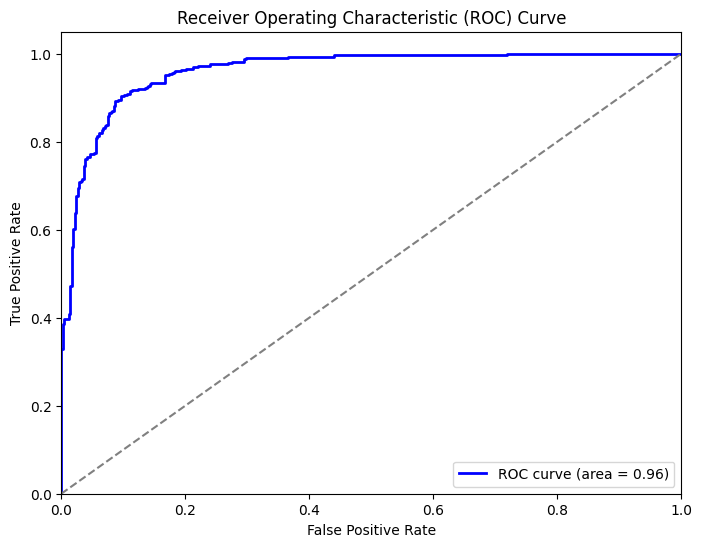

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular as probabilidades previstas
probas = xgb_pipeline.predict_proba(X_valid)

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_valid, probas[:, 1])

# Calcular a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


##### Training with full train data

In [79]:
# defining model
xgb_model_full = XGBClassifier(random_state=0)

# pipeline
xgb_pipeline_full = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model_full)
                             ])

# fit
xgb_pipeline_full.fit(X_full,y_full)
xgb_pipeline_full.score(X_valid,y_valid)


1.0

In [82]:

xgb_predicts_full = xgb_pipeline_full.predict(X_valid)
auc_roc_valid = accuracy_score(y_valid, xgb_predicts_full)
auc_roc_valid

1.0

### Tunning

In [85]:
params_xgb = {
                "model__n_estimators": [100,300,500,800,1000,1200,1500,1800,3000,5000],
                "model__learning_rate":[0.001,0,1,0.05, 0.08,0.5,1],
                "model__max_depth": [6,8,10,12,14,16],
                "model__subsample": [0.5, 0.75, 0.8, 0.9,1],
                "model__colsample_bynode": [0.5,0.75,0.8,1],
                "model__num_parallel_tree":[1,2],
                "model__random_state":[0,36,100]
             }

In [86]:
xgb_random_search =  RandomizedSearchCV(xgb_pipeline_full,param_distributions=params_xgb, scoring='accuracy', cv=cv, n_jobs=1)

In [87]:
xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=36, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['Size',
                                                                                'Weight',
                                                                                'Sweetness',
                                                                                'Crunchiness',
                                                                                'Juiciness',
                                                                                'Ripeness',
                                                                                'Acidity']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('oneh...
                   n_jobs=1,
                   param_distributions={'model__colsample_bynode': [0.5, 0.75,
                                                                    0.8, 1],
                                        'model__learning_rate': [0.001, 0, 1,
                                                                 0.05, 0.08,
                                                                 0.5, 1],
                                        'model__max_depth': [6, 8, 10, 12, 14,
                                                             16],
                                        'model__n_estimators': [100, 300, 500,
                                                                800, 1000, 1200,
                                                                1500, 1800,
                                                                3000, 5000],
                                        'model__num_parallel_tree': [1, 2],
                                        'model__random_state': [0, 36, 100],
                                        'model__subsample': [0.5, 0.75, 0.8,
                                                             0.9, 1]},
                   scoring='accuracy')

In [88]:
xgb_random_search.best_params_

{'model__subsample': 0.5,
 'model__random_state': 0,
 'model__num_parallel_tree': 2,
 'model__n_estimators': 300,
 'model__max_depth': 14,
 'model__learning_rate': 0.08,
 'model__colsample_bynode': 1}

In [89]:
xgb_random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Size', 'Weight',
                                                   'Sweetness', 'Crunchiness',
                                                   'Juiciness', 'Ripeness',
                                                   'Acidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('min_max_scaler',
                                                                   StandardScaler(wit...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=14, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=2, random_state=0, ...))])

In [92]:
# defining model
xgb_model_tunned = XGBClassifier(subsample=0.5,
                                 random_state= 0,
                                 num_parallel_tree= 2,
                                 n_estimators= 300,
                                 max_depth= 14,
                                 learning_rate= 0.08,
                                 colsample_bynode= 1)

# pipeline
xgb_pipeline_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model_tunned)
                             ])

# fit
xgb_pipeline_tuned.fit(X_full,y_full) # training with full dataset

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Size', 'Weight',
                                                   'Sweetness', 'Crunchiness',
                                                   'Juiciness', 'Ripeness',
                                                   'Acidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('min_max_scaler',
                                                                   StandardScaler(wit...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=14, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=2, random_state=0, ...))])

In [93]:
roc_auc_xgb_tunned = cross_val_score(xgb_pipeline_tuned, X_valid, y_valid,
                              cv=cv, scoring='accuracy')

print("XGB Accuracy (Tunned):\n", roc_auc_xgb_tunned.mean())

XGB Accuracy (Tunned):
 0.8625


In [130]:
y_pred = xgb_pipeline_tuned.predict(X_valid)
    
accuracy = accuracy_score(y_valid, y_pred)
    
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_valid, y_pred))

Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00       387

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



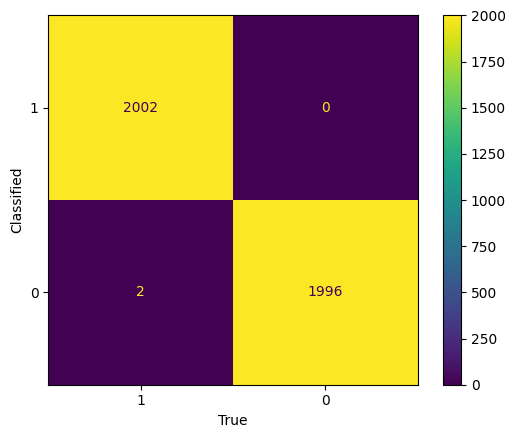

,Sensitividade,Especificidade,Acurácia
0,0.999002,1.0,0.9995


In [129]:
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores


# In[ ]: Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
X_full['phat'] = xgb_pipeline_full.predict(X_full)

#Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=y_full,
                predicts=X_full['phat'],
                cutoff=0.50)